#### impoort packages

In [82]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt


#### Reading the data file

In [83]:
train_filename = 'customeraffinity.train'
data = pd.read_csv(train_filename, sep=',')



In [84]:
len(data.new_user.unique())


92088

In [85]:

len(data.new_item.unique())

3561

In [86]:
data.new_user= data.new_user.astype('category').cat.codes.values

In [87]:
data.new_item = data.new_item.astype('category').cat.codes.values


#### Split the data to 0.8 for training and 0.2 for testing

In [88]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

In [89]:
import keras

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(data.new_user.unique()), len(data.new_item.unique())
n_latent_factors = 3

#### First Model : Matrix factorisation

In [35]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error',metrics=['accuracy'])

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [90]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':


In [67]:
from keras.optimizers import Adam

n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


#### Fit the model

In [91]:
history = model.fit([train.new_user.values, train.new_item.values], train.rating.values,validation_split=0.10, epochs=30, verbose=1)

Train on 1826426 samples, validate on 202937 samples
Epoch 1/30
1826426/1826426 [==============================] - 183s 100us/step - loss: 4.6392 - val_loss: 1.7916
Epoch 2/30
1826426/1826426 [==============================] - 173s 95us/step - loss: 1.4003 - val_loss: 1.3177
Epoch 3/30
1826426/1826426 [==============================] - 181s 99us/step - loss: 1.1352 - val_loss: 1.1852
Epoch 4/30
1826426/1826426 [==============================] - 180s 99us/step - loss: 1.0433 - val_loss: 1.1266
Epoch 5/30
1826426/1826426 [==============================] - 186s 102us/step - loss: 0.9990 - val_loss: 1.0951
Epoch 6/30
1826426/1826426 [==============================] - 180s 99us/step - loss: 0.9725 - val_loss: 1.0777
Epoch 7/30
1826426/1826426 [==============================] - 178s 98us/step - loss: 0.9556 - val_loss: 1.0629ETA: 0s - loss: 0
Epoch 8/30
1826426/1826426 [==============================] - 185s 101us/step - loss: 0.9437 - val_loss: 1.0507
Epoch 9/30
1826426/1826426 [===========

#### Save the model

In [92]:
model.save("model2.hm5")

#### Plot the loss function for train and validation dataset

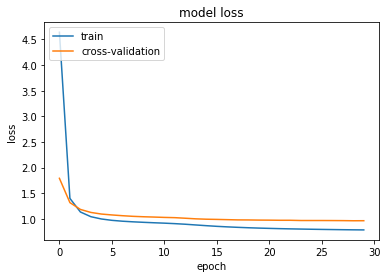

In [93]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'cross-validation'], loc='upper left')
plt.show()


#### round off our prediction to the nearest integer

In [94]:
y_hat = np.round(model.predict([test.new_user, test.new_item]),0)
y_true = test.rating.values

In [95]:
print(np.unique(y_hat))

[ 0.  1.  2.  3.  4.  5.  6.  7.]


In [96]:
print y_hat
l=[]
for i in y_hat:
    l.append(int(i[0]))

for i,k in enumerate(l):
    if k <= 0 :
        l[i]=1
    if k >= 5 :
        l[i]=5

[[ 3.]
 [ 3.]
 [ 4.]
 ..., 
 [ 4.]
 [ 3.]
 [ 3.]]


In [98]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
mean_absolute_error(y_true, l)

0.70242696726659193

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_hat)

In [79]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[   749   2272  11710   7327    785]
 [   339   2337  28798  17741   1006]
 [   192   1956  66935  73161   3711]
 [    90    809  41102 119083  11287]
 [    72    402  11808  73477  30192]]


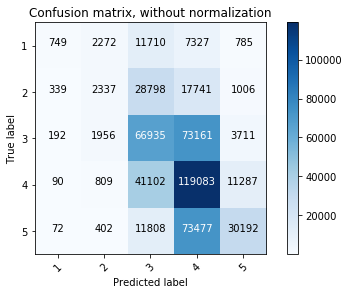

In [80]:
import itertools

plt.figure()
plot_confusion_matrix(cm, classes=['1','2','3','4','5'], title='Confusion matrix, without normalization')
plt.show()

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         28496       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         460445      User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, '_model.pkl')
